In [76]:
# 再度コードを実行するための準備
import pandas as pd
import numpy as np

# ファイルのパス
file_path = '中間成果物/所在管理MBデータ_統合済&特定日時抽出済&手配数と手配運用情報統合済.csv'

# CSVファイルの読み込み（エンコーディングを cp932 に設定）
try:
    data = pd.read_csv(file_path, encoding='cp932')
except Exception as e:
    print(e)

# '検収日時'カラムを日時型に変換
data['検収日時'] = pd.to_datetime(data['検収日時'], errors='coerce')

# 日時型に変換したカラムから日付の部分を抽出
data['検収日'] = data['検収日時'].dt.day

#①品番と納入便ごとにかんばん数を計算
kanban_count = data.groupby(['仕入先名','品番','検収日','納入便','納入回数（間隔）','納入回数（回数）','納入回数（遅れ）']).size().reset_index(name='かんばん数')
bin_count = data.groupby(['仕入先名','品番','納入回数（間隔）','納入回数（回数）','納入回数（遅れ）'])['日量数（箱数）'].max().reset_index(name='最大日量数（箱数）')
nichiryo_count = data.groupby(['仕入先名','品番', '検収日','納入回数（間隔）','納入回数（回数）','納入回数（遅れ）'])['日量数（箱数）'].mean().reset_index(name='日量数（箱数）2')
# 品番と検収日ごとに納入便のユニークな値の数を計算
unique_deliveries = data.groupby(['品番', '検収日'])['納入便'].nunique().reset_index(name='ユニークな納入便の数')

result = pd.merge(kanban_count, bin_count, on=['仕入先名','品番','納入回数（間隔）','納入回数（回数）','納入回数（遅れ）'], how='outer')
result = pd.merge(result, nichiryo_count, on=['仕入先名','品番', '検収日','納入回数（間隔）','納入回数（回数）','納入回数（遅れ）'], how='outer')
result = pd.merge(result, unique_deliveries, on=['品番', '検収日'], how='outer')

#------ピッチと結合
pitch = pd.read_csv('中間成果物/不等ピッチデータ_統合済.csv', encoding='Shift_JIS')
longi = len(result.loc[:,"品番"])
longj = len(pitch.loc[:,"仕入先名"])

for i in range(longi):
    for j in range(longj):
        if (result.loc[i, '仕入先名'] == pitch.loc[j,'仕入先名']):
            result.loc[i,"不等ピッチ係数"] = pitch.loc[j,"不等ピッチ係数【日】"]
            break
            
#-----終了

print("end")

#------在庫と結合
zaiko = pd.read_csv('中間成果物/在庫推移MBデータ_統合済.csv', encoding='Shift_JIS')
# '検収日時'カラムを日時型に変換
zaiko['計測日時'] = pd.to_datetime(zaiko['計測日時'], errors='coerce')
# 日時型に変換したカラムから日付の部分を抽出
zaiko['検収日'] = zaiko['計測日時'].dt.day

zaiko2 = zaiko.groupby(['品番','検収日'])['在庫数（箱）'].mean().reset_index(name='日在庫数（箱）')
zaiko3 = zaiko.groupby(['品番','検収日'])['入庫数（箱）'].sum().reset_index(name='合計入庫数（箱）')
zaiko4 = zaiko.groupby(['品番','検収日'])['出庫数（箱）'].sum().reset_index(name='合計出庫数（箱）')

result = pd.merge(result, zaiko2, on=['品番','検収日'], how='outer')
result = pd.merge(result, zaiko3, on=['品番','検収日'], how='outer')
result = pd.merge(result, zaiko4, on=['品番','検収日'], how='outer')
            
#-----終了

result['不等ピッチ在庫']=result['不等ピッチ係数']*result['最大日量数（箱数）']
result['最大便Ave']=result['最大日量数（箱数）']/result['納入回数（回数）']
result['便Ave+不等ピッチ在庫']=result['最大便Ave']+result['不等ピッチ在庫']
result['差分']=result['かんばん数']-result['便Ave+不等ピッチ在庫']

result['設計値MIN'] = np.ceil(0.1*(result['最大日量数（箱数）']*result['納入回数（間隔）']*(1+result['納入回数（遅れ）'])/result['納入回数（回数）']))
result['設計値MAX'] = result['設計値MIN'] + np.ceil(result['便Ave+不等ピッチ在庫'])
result['在庫数/設計値MAX'] = result['日在庫数（箱）']/result['設計値MAX']

with open("kari2.csv", mode='w',newline='', encoding='shift_jis',errors='ignore') as f:
    result.to_csv(f)
    
# 計算結果の確認
display(result)

end


,仕入先名,品番,検収日,納入便,納入回数（間隔）,納入回数（回数）,納入回数（遅れ）,かんばん数,最大日量数（箱数）,日量数（箱数）2,...,日在庫数（箱）,合計入庫数（箱）,合計出庫数（箱）,不等ピッチ在庫,最大便Ave,便Ave+不等ピッチ在庫,差分,設計値MIN,設計値MAX,在庫数/設計値MAX
0,アイコー（株）,3559850A010,1,1.0,1.0,2.0,3.92,1.0,3.77,3.37,...,4.666667,3.0,4.0,1.2064,1.885,3.0914,-2.0914,1.0,5.0,0.933333
1,アイコー（株）,3559850A010,1,2.0,1.0,2.0,3.92,2.0,3.77,3.37,...,4.666667,3.0,4.0,1.2064,1.885,3.0914,-1.0914,1.0,5.0,0.933333
2,アイコー（株）,3559850A010,4,1.0,1.0,2.0,3.92,1.0,3.77,3.30,...,3.541667,1.0,2.0,1.2064,1.885,3.0914,-2.0914,1.0,5.0,0.708333
3,アイコー（株）,3559850A010,5,2.0,1.0,2.0,3.92,2.0,3.77,3.26,...,3.250000,3.0,3.0,1.2064,1.885,3.0914,-1.0914,1.0,5.0,0.650000
4,アイコー（株）,3559850A010,6,1.0,1.0,2.0,3.92,2.0,3.77,3.24,...,3.541667,5.0,4.0,1.2064,1.885,3.0914,-1.0914,1.0,5.0,0.708333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11490,NaN,Y021782011*****,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11491,NaN,Y021782011*****,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11492,NaN,Y021782011*****,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.250000,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11493,NaN,Y021782011*****,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.529412,37.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
#ライブラリのimport
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re 
import time
import shutil
import shap
import locale
import seaborn as sns
import matplotlib as mpl
from dateutil.relativedelta import relativedelta
from IPython.display import display, clear_output
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from matplotlib.gridspec import GridSpec
from datetime import datetime
from PIL import Image

In [99]:
# 再度データを読み込む
file_path = 'kari2.csv'
data = pd.read_csv(file_path, encoding='shift_jis')  # 前回のエンコーディングを使用

# 欠損値がある行を削除
data_cleaned = data.dropna(subset=['日在庫数（箱）'])

# 「前日の在庫数」「2日前の在庫数」「3日前の在庫数」を計算して追加する準備
# 同一品番ごとにグループ化し、検収日に基づいてソート
data_cleaned.sort_values(by=['品番', '検収日'], inplace=True)

data_cleaned2 = data_cleaned.copy()

# 同一品番内での「日在庫数（箱）」のシフトを行い、新たな列を追加
data_cleaned2.loc[:,'前日の合計入庫数（箱）'] = data_cleaned.groupby('品番')['合計入庫数（箱）'].shift(1)
data_cleaned2.loc[:,'2日前の合計入庫数（箱）'] = data_cleaned.groupby('品番')['合計入庫数（箱）'].shift(2)
data_cleaned2.loc[:,'3日前の合計入庫数（箱）'] = data_cleaned.groupby('品番')['合計入庫数（箱）'].shift(3)

data_cleaned2.loc[:,'前日の合計出庫数（箱）'] = data_cleaned.groupby('品番')['合計出庫数（箱）'].shift(1)
data_cleaned2.loc[:,'2日前の合計出庫数（箱）'] = data_cleaned.groupby('品番')['合計出庫数（箱）'].shift(2)
data_cleaned2.loc[:,'3日前の合計出庫数（箱）'] = data_cleaned.groupby('品番')['合計出庫数（箱）'].shift(3)

with open("kari3.csv", mode='w',newline='', encoding='shift_jis',errors='ignore') as f:
    data_cleaned2.to_csv(f)

# 新たに追加された列の最初の数行を表示して確認
#data_cleaned2[['品番', '検収日', '日在庫数（箱）', '前日の在庫数', '2日前の在庫数', '3日前の在庫数']].head()

/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


MSE: 6.120598112627677


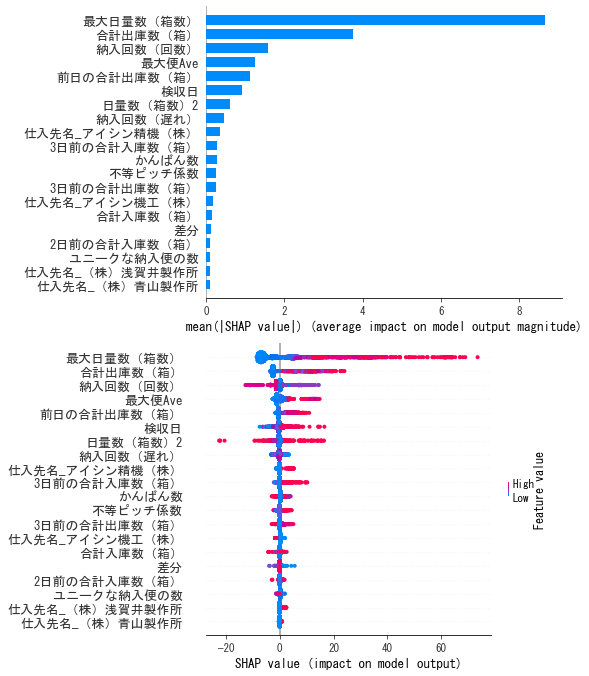

In [102]:
# 再度データを読み込む
file_path = 'kari3.csv'
data = pd.read_csv(file_path, encoding='shift_jis')  # 前回のエンコーディングを使用

targets = '日在庫数（箱）'

# オブジェクト型（テキストベースのカテゴリ変数）の列を選択
# ここでは '品番' 以外のカテゴリ変数を選択
categorical_cols = data.select_dtypes(include=['object']).columns
categorical_cols = categorical_cols[categorical_cols != '品番']  # '品番' 列を除外

# 選択したカテゴリ変数にOne-Hotエンコーディングを適用
# pd.get_dummies関数を使用してエンコーディングを行う
data = pd.get_dummies(data, columns=categorical_cols)

# 不要な「Unnamed」列を削除                
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

# 数値データの列のみを選択する
# ここでは、float64型とint64型のデータ型を持つ列のみを対象としている
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

data_cleaned = data.copy()
data_cleaned[numerical_cols] = data_cleaned[numerical_cols].replace([np.inf, -np.inf], np.nan)
data_cleaned = data_cleaned.dropna(subset=numerical_cols)

data_cleaned = data_cleaned.drop(columns=['品番'])
data_cleaned = data_cleaned.drop(columns=['不等ピッチ在庫'])
data_cleaned = data_cleaned.drop(columns=['設計値MAX'])
data_cleaned = data_cleaned.drop(columns=['設計値MIN'])
data_cleaned = data_cleaned.drop(columns=['在庫数/設計値MAX'])
data_cleaned = data_cleaned.drop(columns=['便Ave+不等ピッチ在庫'])

y = data_cleaned[targets]
X = data_cleaned.drop(columns=targets)

# yを1次元配列に変換
y = y.values.ravel()

# データを学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# ランダムフォレストモデルの訓練
rf_model = RandomForestRegressor(n_estimators=10, random_state=42)
rf_model.fit(X_train, y_train)
# テストデータで予測し、MSEを計算
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

#SHAP計算
#explainer = shap.TreeExplainer(rf_model, feature_perturbation='tree_path_dependent', model_output='raw')
explainer = shap.TreeExplainer(rf_model, feature_dependence='tree_path_dependent', model_output='margin')#古い環境はこっちかも
shap_values = explainer.shap_values(X)

# フォント設定の変更（日本語対応のため）
mpl.rcParams['font.family'] = 'MS Gothic'

# グリッドレイアウトの設定
fig = plt.figure(figsize=(128, 128))
gs = GridSpec(2, 1, figure=fig)

# SHAPサマリープロット
ax = fig.add_subplot(gs[0, 0])
shap.summary_plot(shap_values, X, feature_names=X.columns, plot_type="bar", show=False)

# 平均絶対SHAP値のバープロット
ax = fig.add_subplot(gs[1, 0])
shap.summary_plot(shap_values, X, feature_names=X.columns, show=False)

plt.tight_layout()

In [149]:
from openpyxl import load_workbook
import pandas as pd

# ファイルパスを設定
file_path = 'test.xlsm'  # 実際のファイルパスに修正してください

# ワークブックを読み込む（値だけを読み込む）
wb = load_workbook(filename=file_path, read_only=True, data_only=True)

# 最初のシートを選択
sheet = wb[wb.sheetnames[0]]

# 列名を格納するためのリストを初期化
columns = []

# 2行目（列名となる行）から列名を読み込む
for row in sheet.iter_rows(min_row=2, max_row=2, values_only=True):
    columns = list(row)

# データを格納するためのリストを初期化
data = []

# 3行目以降のデータを読み込む
for row in sheet.iter_rows(min_row=3, values_only=True):
    data.append(row)

# データフレームに変換し、列名を設定
df = pd.DataFrame(data, columns=columns)

# 2番目の列の名前を 'newName' に変更
df.columns.values[8] = '乗務員数11月'
df.columns.values[9] = '車格11月'
df.columns.values[22] = '乗務員数12月'
df.columns.values[36] = '乗務員数1月'

# データフレームの確認
df.head()

,G間輸送\n検索値,G間輸送\n対象,社名,ルートNo.,自社管理ルート名称,遠距離\n近距離,輸送業者,車数,乗務員数11月,車格11月,...,N+1月減便理論可能便数,N+2月容積/重量勝ち,N+2月95％\n理論便数（小数点）,N+2月95％\n理論便数,N+2月減便理論可能便数,N+1月\n減便見込み,N+2月\n減便見込み,N月容積,N+1月容積,N+2月容積
0,ADS東海興運高岡BC（ADS半田第1）A便,None,ADS,請求書H1,東海興運高岡BC（ADS半田第1）A便,近距離,ｾﾝﾀｰﾘﾊﾞｰ,1.0,2.0,15,...,0,容積勝ち,4.4607,4,1,None,1便減便,137.260,136.170,127.130
1,ADS東海興運高岡BC（ADS半田第1）B便,None,ADS,請求書H2,東海興運高岡BC（ADS半田第1）B便,近距離,ｾﾝﾀｰﾘﾊﾞｰ,1.0,2.0,15,...,0,容積勝ち,4.3186,4,1,None,1便減便,131.520,130.920,123.080
2,ADS岡通矢作・半田シャトル,None,ADS,請求書,岡通矢作・半田シャトル,近距離,ｾﾝﾀｰﾘﾊﾞｰ,1.0,2.0,4,...,0,重量勝ち,12.5849,13,0,None,None,145.880,138.330,141.600
3,ADSたいへい倉庫・大府物流S,None,ADS,Ｋ033-17,たいへい倉庫・大府物流S,近距離,大和高速,1.0,2.0,11,...,1,容積勝ち,1.48496,1,1,1便減便,1便減便,21.980,31.184,39.500
4,ADSKCC②④⑥ (ADS半田）・大府BC・東海高岡,None,ADS,請求書H５,KCC②④⑥ (ADS半田）・大府BC・東海高岡,近距離,ｾﾝﾀｰﾘﾊﾞｰ,1.0,2.0,15,...,1,容積勝ち,4.52196,5,0,1便減便,None,120.788,119.228,128.876


In [113]:
display(columns)

['G間輸送\n検索値',
 'G間輸送\n対象',
 '社名',
 'ルートNo.',
 '自社管理ルート名称',
 '遠距離\n近距離',
 '輸送業者',
 '車数',
 '乗務員数',
 '車格',
 '満載\n係数\n(m3/車)',
 '満載\n係数\n(t/車)',
 '輸送費/日',
 '荷量/日\n（㎥）',
 '荷量/日\n（ｔ）',
 '理論便数\n（容積）',
 '理論便数\n（重量）',
 '実行便数',
 '積載率\n（容積）',
 '積載率\n（重量）',
 '輸送業者',
 '車数',
 '乗務員数',
 '車格',
 '満載\n係数\n(m3/車)',
 '満載\n係数\n(t/車)',
 '輸送費/日',
 '荷量/日\n（㎥）',
 '荷量/日\n（ｔ）',
 '理論便数\n（容積）',
 '理論便数\n（重量）',
 '実行便数',
 '積載率\n（容積）',
 '積載率\n（重量）',
 '輸送業者',
 '車数',
 '乗務員数',
 '車格',
 '満載\n係数\n(m3/車)',
 '満載\n係数\n(t/車)',
 '輸送費/日',
 '荷量/日\n（㎥）',
 '荷量/日\n（ｔ）',
 '理論便数\n（容積）',
 '理論便数\n（重量）',
 '実行便数',
 '積載率\n（容積）',
 '積載率\n（重量）',
 'コメント',
 '11月\nMAX積載',
 '12月\nMAX積載',
 '1月\nMAX積載',
 'N月\n70%未満',
 'N+1月\n70%未満',
 'N+2月\n70%未満',
 '次月以降積載回復',
 '次次月以降積載回復',
 'Ｎ+1月\n積載悪化',
 'Ｎ+2月\n積載悪化',
 '慢性\n低積載',
 '要確認\n対象ルート',
 '空白',
 'N月\n100%超過',
 'N+1月\n100%超過',
 'N+2月\n100%超過',
 'G間慢性',
 '70％荷量\n㎥/日',
 '70％荷量\nt/日',
 '容積勝\n70％時\n円/㎥',
 '重量勝\n70％時\n円/t',
 '現在㎥単価',
 '現在t単価',
 '容積\n70％時\n輸送費\n(円/日）',
 '重量\n70％時\n輸送費\n(円/日）',
 '容積ベース\nロス費用',
 '重量ベース\nロス費用',
 '70％未満によるロス費用',
 '85％荷量\n㎥/日',
 '85％荷量\nt/日',
 '容積\n85％時\n円/㎥',
 '重量\n85％時\n円/t',
 '現在㎥単価',
 '現在重量単価',
 '容積勝\n85％時\n輸送費\n(円/日）',
 '重量勝ち\n85％時\n輸送費\n(円/日）',
 '容積ベース\nロス費用',
 '重量ベース\nロス費用',
 '85％積載\n効果見込み',
 '輸送距離(km/日)',
 '1kmあたり\n㎥orｔ単価',
 '85%時\n1kmあたり\n㎥orｔ単価',
 '想定㎥個建単価\n85％単価*1.3',
 '想定t個建単価\n85％単価*1.3',
 '空白',
 '対象納入先',
 '低積載要因1',
 '低積載要因2',
 '代表\n発地',
 '代表\n着地',
 '個社改善検討実施\n（〇or×）',
 '個社改善納期\nCF列〇\n対象',
 '個社改善取り組み内容',
 '改善着手のための課題\n※着手困難な要因',
 '前月N+2\n状況',
 '前月\n次月以降積載回復',
 '前月同様\n3か月低積載\n⇒慢性ルート',
 '今回重点フォロールート',
 None,
 'N月容積/重量勝ち',
 'N月95％\n理論便数（小数点）',
 'N月95％\n理論便数',
 'N月減便理論可能便数',
 'N+1月容積/重量勝ち',
 'N+1月95％\n理論便数（小数点）',
 'N+1月95％\n理論便数',
 'N+1月減便理論可能便数',
 'N+2月容積/重量勝ち',
 'N+2月95％\n理論便数（小数点）',
 'N+2月95％\n理論便数',
 'N+2月減便理論可能便数',
 'N+1月\n減便見込み',
 'N+2月\n減便見込み',
 'N月容積',
 'N+1月容積',
 'N+2月容積']

In [186]:
# 'コラムA'が0でない行だけを選択して新しいデータフレームに保存
df_filtered = df[df['遠距離\n近距離'] != "遠距離"]

# データフレームの列名が 'columnName' である列の合計を計算
total = df_filtered['乗務員数11月'].sum()
display("合計台数",total)

sakugendekiru = total*0.2
display("削減できる台数",sakugendekiru)

df2 = df_filtered.copy()

# '車格11月'列から特定の文字列を数値に置換し、数値に一致する部分だけを抽出し、結果を数値型に変換
df2['車格11月'] = df_filtered['車格11月'].astype(str).str.replace("ﾌﾙﾄﾚ", "15")
df2['車格11月'] = df2['車格11月'].str.extract('([-+]?[0-9]+\.?[0-9]*)', expand=False)
df2['車格11月'] = pd.to_numeric(df2['車格11月'], errors='coerce')

# 結果を表示して確認
display("合計台数",df2['車格11月'])

# '車格11月'列の値に基づいて'単価'列の値を設定
df2.loc[df2['車格11月'] < 11, '単価'] = 3
df2.loc[(df2['車格11月'] >= 11) & (df2['車格11月'] < 15), '単価'] = 4
df2.loc[df2['車格11月'] >= 15, '単価'] = 4.5

#
df2["削減できる台数"]=(df2['乗務員数11月']/total)*sakugendekiru

display("削減できる台数",df2['削減できる台数'])

df2["削減金額"]=df2["削減できる台数"]*df2["単価"]

total = df2['削減金額'].sum()
display("合計削減金額",total)

'合計台数'

706.0

'削減できる台数'

141.20000000000002

'合計台数'

0      15.0
1      15.0
2       4.0
3      11.0
4      15.0
       ... 
831     NaN
832     NaN
833     NaN
834     NaN
835     NaN
Name: 車格11月, Length: 778, dtype: float64

'削減できる台数'

0      0.4
1      0.4
2      0.4
3      0.4
4      0.4
      ... 
831    NaN
832    NaN
833    NaN
834    NaN
835    NaN
Name: 削減できる台数, Length: 778, dtype: float64

'合計削減金額'

595.8000000000001

In [151]:
display(df['車格11月'])
display(df2['車格11月'])

0        15
1        15
2         4
3        11
4        15
       ... 
831    None
832    None
833    None
834    None
835    None
Name: 車格11月, Length: 836, dtype: object

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
831    NaN
832    NaN
833    NaN
834    NaN
835    NaN
Name: 車格11月, Length: 836, dtype: object

In [187]:
with open("karidf.csv", mode='w',newline='', encoding='shift_jis',errors='ignore') as f:
    df2.to_csv(f)